# XGBoost

In [8]:
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [9]:
# Load Data
X_train_input = joblib.load("Data/Xtrain1.pkl")
Y_train_input = np.load('Data/Ytrain1.npy')

print(X_train_input.shape)
print(Y_train_input.shape)

(700, 2)
(700,)


In [10]:
# Extract patient IDs
patient_ids = X_train_input["Patient_Id"].values

# Split into train/test (patients 1–3 for test)
mask_test = np.isin(patient_ids, [1, 2, 3])
mask_train = ~mask_test

X_train_df = X_train_input[mask_train]
Y_train = Y_train_input[mask_train]

X_test_df = X_train_input[mask_test]
Y_test = Y_train_input[mask_test]

# Extract feature arrays
X_train = np.vstack(X_train_df["Skeleton_Features"].values)
X_test = np.vstack(X_test_df["Skeleton_Features"].values)


In [11]:
# Get train groups
groups_train = X_train_df["Patient_Id"].values 

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,  # 3 exercise classes
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

cv = LeaveOneGroupOut()

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=cv.split(X_train_scaled, Y_train, groups=groups_train),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)


In [13]:
print("Running grid search...")
grid_search.fit(X_train_scaled, Y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best CV F1-macro: {grid_search.best_score_:.4f}")

Running grid search...
Fitting 11 folds for each of 324 candidates, totalling 3564 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=

In [14]:
best_model = grid_search.best_estimator_

Y_pred = best_model.predict(X_test_scaled)
f1 = f1_score(Y_test, Y_pred, average='macro')


Test F1-score (macro): 0.7387


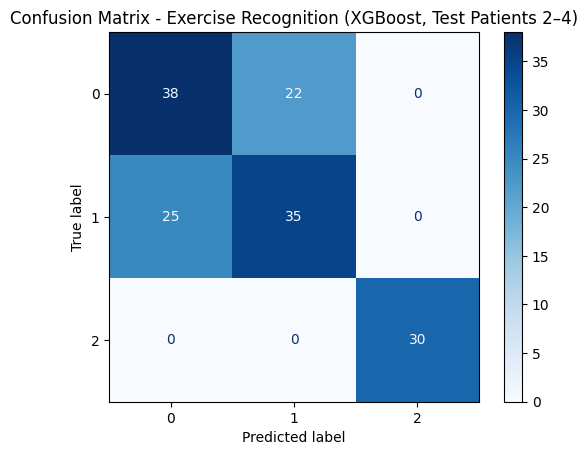

In [ ]:
print(f"\nTest F1-score (macro): {f1:.4f}")

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Exercise Recognition (XGBoost, Test Patients 1–3)")
plt.show()